# Importing Libraries

In [22]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

from prophet import Prophet

import warnings
warnings.filterwarnings("ignore")

# Data Loading, Analysis and Preprocessing

In [4]:
df = pd.read_csv("/kaggle/input/time-series-datasets/Electric_Production.csv")
df.shape

(397, 2)

In [5]:
df.head()

,DATE,IPG2211A2N
0,1/1/1985,72.5052
1,2/1/1985,70.6720
2,3/1/1985,62.4502
3,4/1/1985,57.4714
4,5/1/1985,55.3151


In [7]:
df['DATE'] = pd.to_datetime(df['DATE'])
df.head()

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [8]:
df.describe()

,DATE,IPG2211A2N
count,397,397.000000
mean,2001-07-01 13:25:14.357682560,88.847218
min,1985-01-01 00:00:00,55.315100
25%,1993-04-01 00:00:00,77.105200
50%,2001-07-01 00:00:00,89.779500
75%,2009-10-01 00:00:00,100.524400
max,2018-01-01 00:00:00,129.404800
std,NaN,15.387834


<Axes: xlabel='DATE', ylabel='IPG2211A2N'>

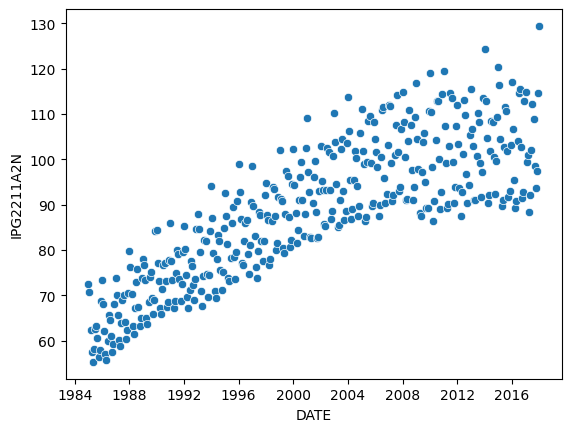

In [9]:
sns.scatterplot(df, x='DATE', y='IPG2211A2N')

<Axes: >

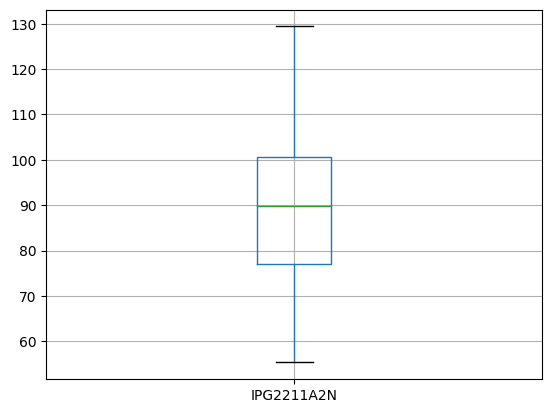

In [10]:
df.boxplot(['IPG2211A2N'])

<Axes: >

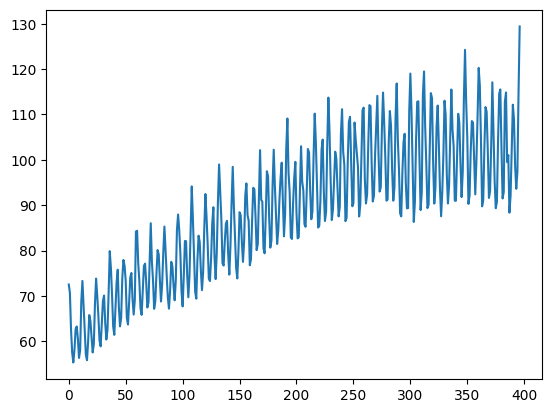

In [11]:
df.IPG2211A2N.plot()

In [13]:
min(df.DATE), max(df.DATE)

(Timestamp('1985-01-01 00:00:00'), Timestamp('2018-01-01 00:00:00'))

In [15]:
l = df.shape[0]
10 / 100 * l

39.7

In [17]:
# df.tail(40)

# Splitting

In [20]:
split_date = "2014-10-01"

In [18]:
df1 = df.set_index('DATE')
df1.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [21]:
train = df1.loc[df1.index <= split_date].copy()
test = df1.loc[df1.index > split_date].copy()
train.shape, test.shape

((358, 1), (39, 1))

# Scaling

In [23]:
ss = StandardScaler()

In [24]:
train_price = np.array(train['IPG2211A2N'])
train_price = train_price.reshape(-1, 1)

test_price = np.array(test['IPG2211A2N'])
test_price = test_price.reshape(-1, 1)

In [25]:
train_ss = ss.fit_transform(train_price)
test_ss = ss.transform(test_price)

In [26]:
train['scaled_IPG2211A2N'] = train_ss
test['scaled_IPG2211A2N'] = test_ss

In [27]:
train.head()

,IPG2211A2N,scaled_IPG2211A2N
DATE,,
1985-01-01,72.5052,-0.983523
1985-02-01,70.6720,-1.105681
1985-03-01,62.4502,-1.653556
1985-04-01,57.4714,-1.985328
1985-05-01,55.3151,-2.129017


In [30]:
test.head()

,IPG2211A2N,scaled_IPG2211A2N
DATE,,
2014-11-01,99.7033,0.828872
2014-12-01,109.3477,1.471545
2015-01-01,120.2696,2.199345
2015-02-01,116.3788,1.940075
2015-03-01,104.4706,1.146550


# Prophet

In [31]:
train_prophet = train.reset_index() \
    .rename(columns={'DATE':'ds',
                     'scaled_IPG2211A2N':'y'})
train_prophet = train_prophet[['ds', 'y']]
train_prophet.head()

,ds,y
0,1985-01-01,-0.983523
1,1985-02-01,-1.105681
2,1985-03-01,-1.653556
3,1985-04-01,-1.985328
4,1985-05-01,-2.129017


In [32]:
test_prophet = test.reset_index() \
    .rename(columns={'DATE':'ds',
                     'scaled_IPG2211A2N':'y'})
test_prophet = test_prophet[['ds', 'y']]
test_prophet.head()

,ds,y
0,2014-11-01,0.828872
1,2014-12-01,1.471545
2,2015-01-01,2.199345
3,2015-02-01,1.940075
4,2015-03-01,1.146550


In [33]:
train_prophet.shape,test_prophet.shape

((358, 2), (39, 2))

## Model Fitting

In [34]:
%%time
model = Prophet()
model.fit(train_prophet)

06:23:03 - cmdstanpy - INFO - Chain [1] start processing
06:23:03 - cmdstanpy - INFO - Chain [1] done processing


CPU times: user 160 ms, sys: 40.5 ms, total: 201 ms
Wall time: 385 ms


## Predicting

In [35]:
test_forecast = model.predict(test_prophet)
test_forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2014-11-01,1.084714,0.429288,0.890215,1.084714,1.084714,-0.420795,-0.420795,-0.420795,-0.420795,-0.420795,-0.420795,0.0,0.0,0.0,0.663919
1,2014-12-01,1.087015,1.228323,1.706351,1.087015,1.087015,0.385154,0.385154,0.385154,0.385154,0.385154,0.385154,0.0,0.0,0.0,1.472170
2,2015-01-01,1.089394,1.702163,2.158206,1.089341,1.089394,0.853657,0.853657,0.853657,0.853657,0.853657,0.853657,0.0,0.0,0.0,1.943051
3,2015-02-01,1.091772,1.254324,1.725390,1.091614,1.091845,0.396328,0.396328,0.396328,0.396328,0.396328,0.396328,0.0,0.0,0.0,1.488100
4,2015-03-01,1.093920,0.841839,1.299105,1.093584,1.094093,-0.022886,-0.022886,-0.022886,-0.022886,-0.022886,-0.022886,0.0,0.0,0.0,1.071034


In [42]:
fv = test_forecast['yhat']
fc = np.array(fv).reshape(-1, 1)
fc.shape

(39, 1)

In [43]:
frv = ss.inverse_transform(fc)
test_forecast['ypred'] = frv

In [44]:
test_forecast = test_forecast[['ds', 'yhat', 'ypred']]
test_forecast.head()

,ds,yhat,ypred
0,2014-11-01,0.663919,97.227889
1,2014-12-01,1.472170,109.357082
2,2015-01-01,1.943051,116.423460
3,2015-02-01,1.488100,109.596140
4,2015-03-01,1.071034,103.337349


<Axes: xlabel='ds', ylabel='ypred'>

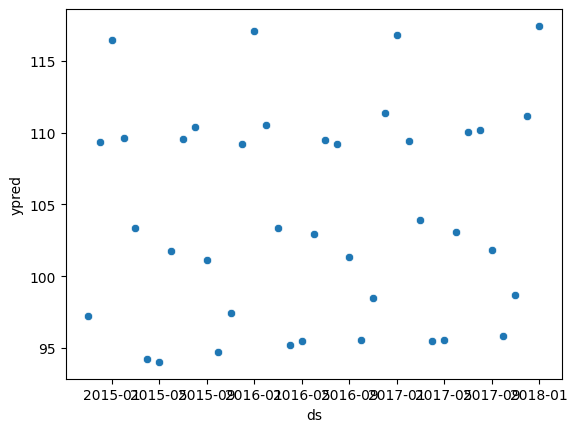

In [45]:
sns.scatterplot(test_forecast, x='ds', y='ypred')

<Axes: >

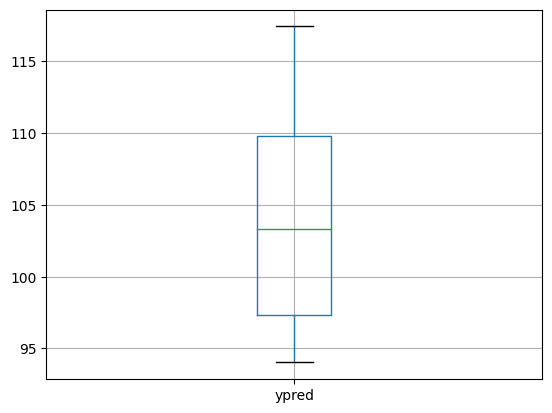

In [46]:
test_forecast.boxplot(['ypred'])

<Axes: >

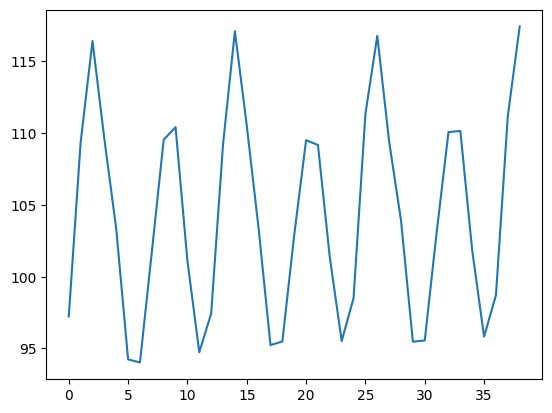

In [47]:
test_forecast.ypred.plot()

In [52]:
ytrue = np.array(test.IPG2211A2N)
ypred = np.array(test_forecast.ypred)

In [53]:
ytrue, ypred

(array([ 99.7033, 109.3477, 120.2696, 116.3788, 104.4706,  89.7461,
         91.093 , 102.6495, 111.6354, 110.5925, 101.9204,  91.5959,
         93.0628, 103.2203, 117.0837, 106.6688,  95.3548,  89.3254,
         90.7369, 104.0375, 114.5397, 115.5159, 102.7637,  91.4867,
         92.89  , 112.7694, 114.8505,  99.4901, 101.0396,  88.353 ,
         92.0805, 102.1532, 112.1538, 108.9312,  98.6154,  93.6137,
         97.3359, 114.7212, 129.4048]),
 array([ 97.22788913, 109.35708239, 116.42346006, 109.59614027,
        103.3373489 ,  94.23443246,  94.02058105, 101.71965308,
        109.54810614, 110.41767503, 101.10105308,  94.73426025,
         97.42746044, 109.21985925, 117.10577027, 110.53355017,
        103.34929843,  95.23347367,  95.48336345, 102.90418496,
        109.51278552, 109.17906604, 101.33434677,  95.51661432,
         98.5019265 , 111.3410969 , 116.7839286 , 109.40707509,
        103.91898032,  95.4695394 ,  95.55403774, 103.05935184,
        110.07421572, 110.15588907, 101.

In [54]:
def evaluation(ytrue, ypred):
    print("Root Mean Squared Error: ", np.sqrt(mean_squared_error(y_true=ytrue, y_pred=ypred)))
    print("Mean Absolute Error: ", mean_absolute_error(y_true=ytrue, y_pred=ypred))
    print("Mean Absolute Percentage Error: ", mean_absolute_percentage_error(y_true=ytrue, y_pred=ypred))
    
evaluation(ytrue, ypred)

Root Mean Squared Error:  4.458025729543589
Mean Absolute Error:  3.552200778358266
Mean Absolute Percentage Error:  0.034864724149851


## Forecasting

In [36]:
future = model.make_future_dataframe(periods=731)
future.tail()

,ds
1084,2016-09-27
1085,2016-09-28
1086,2016-09-29
1087,2016-09-30
1088,2016-10-01


In [37]:
forecasted_value = model.predict(future)
forecasted_value.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1985-01-01,-1.656786,-1.065939,-0.591829,-1.656786,-1.656786,0.821595,0.821595,0.821595,0.821595,0.821595,0.821595,0.0,0.0,0.0,-0.835191
1,1985-02-01,-1.646297,-1.554522,-1.093087,-1.646297,-1.646297,0.327647,0.327647,0.327647,0.327647,0.327647,0.327647,0.0,0.0,0.0,-1.318650
2,1985-03-01,-1.636823,-1.915302,-1.449909,-1.636823,-1.636823,-0.040210,-0.040210,-0.040210,-0.040210,-0.040210,-0.040210,0.0,0.0,0.0,-1.677033
3,1985-04-01,-1.626333,-2.471890,-2.013168,-1.626333,-1.626333,-0.605633,-0.605633,-0.605633,-0.605633,-0.605633,-0.605633,0.0,0.0,0.0,-2.231966
4,1985-05-01,-1.616182,-2.452362,-1.983840,-1.616182,-1.616182,-0.602304,-0.602304,-0.602304,-0.602304,-0.602304,-0.602304,0.0,0.0,0.0,-2.218486


In [55]:
fv = forecasted_value['yhat']
fc = np.array(fv).reshape(-1, 1)
fc.shape

(1089, 1)

In [56]:
frv = ss.inverse_transform(fc)
forecasted_value['ypred'] = frv

In [57]:
forecasted_value = forecasted_value[['ds', 'yhat', 'ypred']]
forecasted_value.head()

,ds,yhat,ypred
0,1985-01-01,-0.835191,74.731174
1,1985-02-01,-1.318650,67.476041
2,1985-03-01,-1.677033,62.097887
3,1985-04-01,-2.231966,53.770165
4,1985-05-01,-2.218486,53.972457


<Axes: xlabel='ds', ylabel='ypred'>

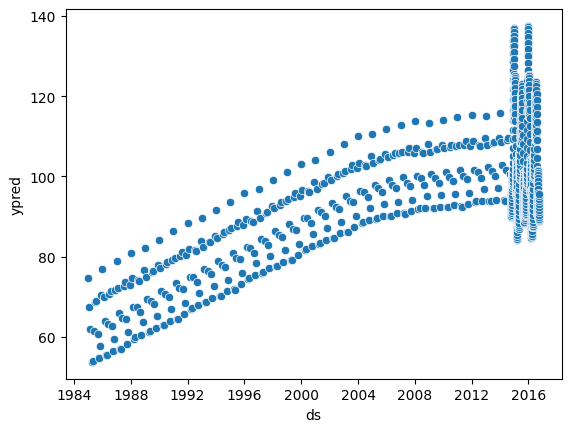

In [59]:
sns.scatterplot(forecasted_value, x='ds', y='ypred')

<Axes: >

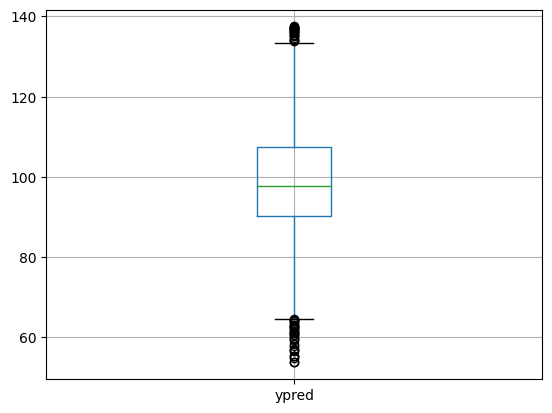

In [60]:
forecasted_value.boxplot(['ypred'])

<Axes: >

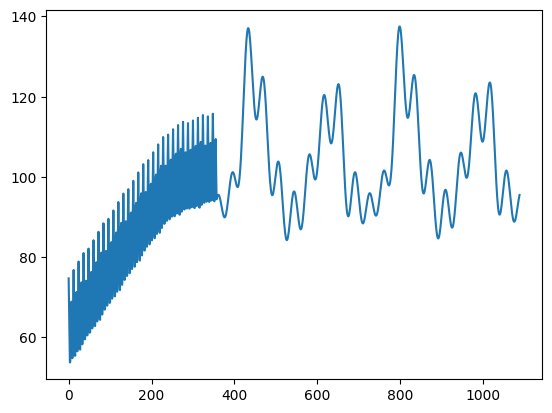

In [61]:
forecasted_value.ypred.plot()